In [1]:
%load_ext watermark
%watermark

Last updated: 2023-11-02T19:25:44.535316-05:00

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.12.2

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [4]:
import pandas as pd
import numpy as np


from IPython.display import Image
from category_encoders import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn import preprocessing, feature_extraction
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier

In [5]:
df_consumo = pd.read_pickle("data/df_consumo_procesado_danny.pkl")

In [6]:
n_records = len(df_consumo)
def valores_inexistentes_col(df):
    for columna in df:
        print("{} | {} | {}".format(
            df[columna].name, len(df[df[columna].isnull()]) / (1.0*n_records), df[columna].dtype
        ))

valores_inexistentes_col(df_consumo)

departamento | 0.0 | object
residentes_hogar | 0.0 | int64
d2_04_num_hijos | 0.0 | int64
per_edad_tipo | 0.0 | category
estrato_tipo | 0.0 | category
situacion_tipo | 0.0 | category
frecuencia_consumo_marihuana_tipo | 0.0 | category
frecuencia_consumo_cocaina_tipo | 0.0 | category
frecuencia_consumo_basuco_tipo | 0.0 | category
per_sexo_tipo | 0.0 | category
vive_padre_hogar_tipo | 0.0 | category
vive_madre_hogar_tipo | 0.0 | category
vivienda_tipo | 0.0 | category
d_01_aporta_dinero_hogar_tipo | 0.0 | category
d_08_estado_salud_tipo | 0.0 | category
d_09_deprimido_tipo | 0.0 | category
d_10_poco_interes_tipo | 0.0 | category
d_11_h_conocimiento_riesgo_fumar_marihuana_frecuentemente_tipo | 0.0 | category
d_11_k_conocimiento_riesgo_cocaina_frecuentemente_tipo | 0.0 | category
d_11_n_conocimiento_riesgo_fumar_basuco_frecuentemente_tipo | 0.0 | category
d_12_b_presenta_problema_consumo_sp_barrio_tipo | 0.0 | category
d_12_c_presenta_problema_expendio_sp_barrio_tipo | 0.0 | category
d2_01_

Como vimos en un apartado anterior, en este ejemplo vamos a modificar cada variable en función de su tipo. Al conjunto de pasos que siguen los datos se le llama comúnmente **Pipelines** (literalmente, sistemas de tuberias).

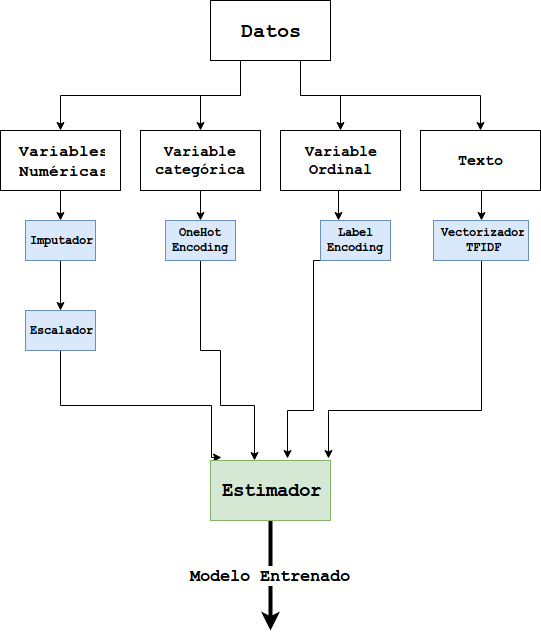

In [7]:
Image("../../media/pipeline.png")

**INCISO**

vamos a modificar dos transformadores de scikitlearn para que sean compatibles con pipelines. Este paso es necesario en la version actual de scikit-learn

In [14]:
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns, output_type="matrix"):
        self.columns = columns
        self.output_type = output_type

    def transform(self, X, **transform_params):
        if isinstance(X, list):
            X = pd.DataFrame.from_dict(X)
        if self.output_type == "matrix":
            return X[self.columns].to_numpy()
        elif self.output_type == "dataframe":
            return X[self.columns]
        raise Exception("output_type tiene que ser matrix o dataframe")
        
    def fit(self, X, y=None, **fit_params):
        return self

In [15]:
# Definir categorías de riesgo
def categorizar_riesgo(valor):
    if valor < -0.933195:  
        return 0
    elif valor < 0.828706:
        return 1
    elif valor < 2.590608:
        return 2
    elif valor < 4.352510:
        return 3
    else:
        return 4

In [16]:
class NumpyArrayToDataFrame(BaseEstimator, TransformerMixin):
    def fit (self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.df(X)

def procesar_con_pca(df):
    
    pca = PCA(n_components=1)
    
    data_pca = pca.fit_transform(df)
    
    # Agregar la puntuación de componente principal como una nueva columna
    df['ComponentePrincipal'] = data_pca
    
    # Aplicar la función de categorización a la puntuación del componente principal
    df['CatRiesgo'] = df['ComponentePrincipal'].apply(categorizar_riesgo)
    
    # Eliminamos el componente principal
    del df['ComponentePrincipal']
    
    return df

En primer lugar vamos a definir los transformadores de forma similar a como hicimos la última vez, solo que en vez de usar `OneHotEncoder` vamos a usar nuestra version de sklearn `LabelBinarizer` que hace la codificación one hot directamente sobre una variable categórica.

In [17]:
from sklearn.impute import SimpleImputer

col_numericas =  ['d2_04_num_hijos','residentes_hogar']
col_categoricas = ['departamento','situacion_tipo','per_sexo_tipo','vive_padre_hogar_tipo','vive_madre_hogar_tipo','vivienda_tipo','d_01_aporta_dinero_hogar_tipo','d_09_deprimido_tipo','d_10_poco_interes_tipo','d_11_h_conocimiento_riesgo_fumar_marihuana_frecuentemente_tipo','d_11_k_conocimiento_riesgo_cocaina_frecuentemente_tipo','d_11_n_conocimiento_riesgo_fumar_basuco_frecuentemente_tipo','d_12_b_presenta_problema_consumo_sp_barrio_tipo','d_12_c_presenta_problema_expendio_sp_barrio_tipo','d2_01_etnia_tipo','d2_03_estado_civil_tipo','d2_05_nivel_educativo_tipo','g_01_familiares_consumen_sp_tipo','g_02_amigos_consumen_sp_tipo','g_03_curiosidad_probar_sp_tipo','g_04_probaria_sp_tipo','g_05_posibilidad_probar_sp_tipo','g_06_a_posibilidad_conseguir_marihuana_tipo','g_06_b_posibilidad_conseguir_cocaina_tipo','g_06_c_posibilidad_conseguir_basuco_tipo','g_07_alguien_ofrecio_comprar_probar_sp_tipo','g_01_a_num_familiares_consumen_sp_imp_tipo','g_02_a_num_amigos_consumen_sp_imp_tipo','g_08_a_ofrecieron_marihuana_imp_tipo','g_08_b_ofrecieron_cocaina_imp_tipo','g_08_c_ofrecieron_basuco_imp_tipo']

dict_var_ordinales = {
    "per_edad_tipo": ["Adolescente", "Joven", "Adulto", "Persona mayor"],
    "estrato_tipo":["Estrato bajo", "Estrato medio", "Estrato alto"],
    "d_08_estado_salud_tipo":["d_08_Muy_malo","d_08_Malo","d_08_Regular","d_08_Bueno","d_08_Muy_bueno"],
    "frecuencia_consumo_marihuana_tipo":["Nunca", "Alguna vez en su vida", "Una vez en el año", "Algunas veces durante los últimos 12 meses", "Algunas veces mensualmente", "Algunas veces semanalmente", "Diariamente"],
    "frecuencia_consumo_cocaina_tipo":["Nunca", "Alguna vez en su vida", "Una vez en el año", "Algunas veces durante los últimos 12 meses", "Algunas veces mensualmente", "Algunas veces semanalmente", "Diariamente"],
    "frecuencia_consumo_basuco_tipo":["Nunca", "Alguna vez en su vida", "Una vez en el año", "Algunas veces durante los últimos 12 meses", "Algunas veces mensualmente", "Algunas veces semanalmente", "Diariamente"],
}

col_ordinales = list(dict_var_ordinales.keys())
datos_ordinales = df_consumo[col_ordinales]
datos_categoricos = df_consumo[col_categoricas]

escalador = preprocessing.MinMaxScaler()

estimador = RandomForestClassifier(n_estimators=100, random_state=42)

Creamos ahora los pipelines para cada tipo de variable. En algunos casos he añadido pasos adicionales por dos motivos. El primero, que determinados elementos de sklearn esperan datos ligeramente distintos. En segundo lugar, para conseguir que la salida de cada pipeline tenga la misma forma (un array de arrays).

In [18]:
pipeline_numerico = Pipeline([
    ["selector_numerico", ColumnExtractor(columns=col_numericas)],
    ["transformador_numerico", Pipeline([
        ("imputador_numerico", SimpleImputer(missing_values=np.nan, strategy='mean')),
        ("escalador_numerico", preprocessing.MinMaxScaler())
    ])]
])

pipeline_numerico.fit_transform(df_consumo)[:5]

array([[0.        , 0.30769231],
       [0.25      , 0.23076923],
       [0.16666667, 0.23076923],
       [0.        , 0.38461538],
       [0.08333333, 0.23076923]])

In [19]:
pipeline_categorico = Pipeline([
    ("selector_categorica", ColumnExtractor(
        columns=col_categoricas,
        output_type="dataframe")),
    ("transformador_categorico", OneHotEncoder(
        cols=col_categoricas, handle_unknown="impute")),
])

pipeline_categorico.fit_transform(df_consumo)[:5]

,departamento_1,departamento_2,departamento_3,departamento_4,departamento_5,departamento_6,departamento_7,departamento_8,departamento_9,departamento_10,...,g_08_b_ofrecieron_cocaina_imp_tipo_1,g_08_b_ofrecieron_cocaina_imp_tipo_2,g_08_b_ofrecieron_cocaina_imp_tipo_3,g_08_b_ofrecieron_cocaina_imp_tipo_4,g_08_b_ofrecieron_cocaina_imp_tipo_5,g_08_c_ofrecieron_basuco_imp_tipo_1,g_08_c_ofrecieron_basuco_imp_tipo_2,g_08_c_ofrecieron_basuco_imp_tipo_3,g_08_c_ofrecieron_basuco_imp_tipo_4,g_08_c_ofrecieron_basuco_imp_tipo_5
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [20]:
niveles_ordinales = []
for col, levels in dict_var_ordinales.items():
    niveles_ordinales.append({"col": col, 
                              "mapping": dict(zip(levels, range(len(levels))))})
niveles_ordinales

[{'col': 'per_edad_tipo',
  'mapping': {'Adolescente': 0, 'Joven': 1, 'Adulto': 2, 'Persona mayor': 3}},
 {'col': 'estrato_tipo',
  'mapping': {'Estrato bajo': 0, 'Estrato medio': 1, 'Estrato alto': 2}},
 {'col': 'd_08_estado_salud_tipo',
  'mapping': {'d_08_Muy_malo': 0,
   'd_08_Malo': 1,
   'd_08_Regular': 2,
   'd_08_Bueno': 3,
   'd_08_Muy_bueno': 4}},
 {'col': 'frecuencia_consumo_marihuana_tipo',
  'mapping': {'Nunca': 0,
   'Alguna vez en su vida': 1,
   'Una vez en el año': 2,
   'Algunas veces durante los últimos 12 meses': 3,
   'Algunas veces mensualmente': 4,
   'Algunas veces semanalmente': 5,
   'Diariamente': 6}},
 {'col': 'frecuencia_consumo_cocaina_tipo',
  'mapping': {'Nunca': 0,
   'Alguna vez en su vida': 1,
   'Una vez en el año': 2,
   'Algunas veces durante los últimos 12 meses': 3,
   'Algunas veces mensualmente': 4,
   'Algunas veces semanalmente': 5,
   'Diariamente': 6}},
 {'col': 'frecuencia_consumo_basuco_tipo',
  'mapping': {'Nunca': 0,
   'Alguna vez en s

In [21]:
pipeline_ordinal = Pipeline([
    ("selector_ordinal", ColumnExtractor(columns=col_ordinales, output_type="dataframe")),
    ("transformador_ordinal", OrdinalEncoder(mapping=niveles_ordinales))
])

#pipeline_ordinal.fit_transform(datos.head()[col_ordinales])
pipeline_ordinal.fit_transform(df_consumo)[:5]

,per_edad_tipo,estrato_tipo,d_08_estado_salud_tipo,frecuencia_consumo_marihuana_tipo,frecuencia_consumo_cocaina_tipo,frecuencia_consumo_basuco_tipo
0,1,0,1,0,0,0
1,2,0,2,0,0,0
2,2,0,3,0,0,0
3,2,2,3,0,0,0
4,1,0,3,0,0,0


Ya tenemos una manera de, dado un conjunto de datos, separarlos y aplicar distintas transformaciones a cada variable. Nos falta una manera de, una vez se han transformado, reunirlas de nuevo.

Para ello podemos usar `FeatureUnion`, que simplemente toma un conjunto de pasos de un pipeline y los une.

In [22]:
pipeline_procesado = FeatureUnion([
    ('variables_numericas', pipeline_numerico),
    ('variables_ordinales', pipeline_ordinal),
    ('variables_categoricas', pipeline_categorico),
])

In [23]:
pipeline_procesado

FeatureUnion(transformer_list=[('variables_numericas',
                                Pipeline(steps=[('selector_numerico',
                                                 ColumnExtractor(columns=['d2_04_num_hijos',
                                                                          'residentes_hogar'])),
                                                ['transformador_numerico',
                                                 Pipeline(steps=[('imputador_numerico',
                                                                  SimpleImputer()),
                                                                 ('escalador_numerico',
                                                                  MinMaxScaler())])]])),
                               ('variables_ordinales',
                                Pipeline(steps=[('selector_ordinal',
                                                 ColumnExtr...
                                                                     'g_06_a_posibilidad_conseguir_marihuana_tipo',
                                                                     'g_06_b_posibilidad_conseguir_cocaina_tipo',
                                                                     'g_06_c_posibilidad_conseguir_basuco_tipo',
                                                                     'g_07_alguien_ofrecio_comprar_probar_sp_tipo',
                                                                     'g_01_a_num_familiares_consumen_sp_imp_tipo',
                                                                     'g_02_a_num_amigos_consumen_sp_imp_tipo',
                                                                     'g_08_a_ofrecieron_marihuana_imp_tipo',
                                                                     'g_08_b_ofrecieron_cocaina_imp_tipo', ...],
                                                               handle_unknown='impute'))]))])

In [24]:
numpy_resultante = pipeline_procesado.fit_transform(df_consumo)

In [25]:
pipelineTransformador = Pipeline ([
    ('numpy_to_dataframe', FunctionTransformer(lambda x: pd.DataFrame(x))),
    ('pca_processor', FunctionTransformer(lambda x: procesar_con_pca(x), validate=False))
])

In [26]:
data_frame = pipelineTransformador.transform(numpy_resultante)

In [27]:
# Límite inferior
limite_inferior = np.min(data_frame['ComponentePrincipal'])

# Límite superior
limite_superior = np.max(data_frame['ComponentePrincipal'])

# Número de rangos
num_rangos = 5

# Calcula el tamaño de cada rango
tamanio_rango = (limite_superior - limite_inferior) / num_rangos

# Inicializa una lista para almacenar los límites de los rangos
limites_rangos = []

# Calcula los límites de los rangos
for i in range(num_rangos):
    limite_rango_inferior = limite_inferior + (i * tamanio_rango)
    limite_rango_superior = limite_inferior + ((i + 1) * tamanio_rango)
    limites_rangos.append((limite_rango_inferior, limite_rango_superior))

# Imprime los límites de los rangos
for i, (limite_inf, limite_sup) in enumerate(limites_rangos):
    print(f"Rango {i+1}: De {limite_inf:.6f} a {limite_sup:.6f}")

KeyError: 'ComponentePrincipal'

In [28]:
data_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,136,137,138,139,140,141,142,143,144,CatRiesgo
0,0.000000,0.307692,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,0.250000,0.230769,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2,0.166667,0.230769,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,0.000000,0.384615,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,0.083333,0.230769,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


In [29]:
df_consumo['CatRiesgo'] = data_frame['CatRiesgo']

Finalmente, exportamos el data set en formato csv con la nueva variable creada

In [30]:
df_consumo.to_csv("data/df_consumo_varObjetivo.csv", index=False)

In [31]:
data_frame.to_csv("data/df_codificado_varObjetivo.csv", index=False)